# XGBoost & SHAP - experiment simulation 


I am using the conda environment version 22.04 http://climate-cms.wikis.unsw.edu.au/Conda#22.04

### In this notebook:

- We tune, train and test an XGBoost model on the ACCESS-AM2 cloud and radiative biases for the 'ice' run, where we have reduced the ice crystal shape parameter to 0.5 (from 1) to slow the ice cyrstal growth rates
- We then generate the SHAP values for analysis 

In [1]:
import sys
import os
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
import xarray as xr
#matplotlib.rcParams['pdf.fonttype'] = 42
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV   
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import shap


In [2]:
from dask.distributed import Client,LocalCluster
client = Client()

unclosed <socket.socket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 8787)>
Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33605 instead


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33605/status,
Dashboard: http://127.0.0.1:33605/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43541,Workers: 4
Dashboard: http://127.0.0.1:33605/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:42777,Total threads: 4
Dashboard: http://127.0.0.1:38159/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:42347,


# Read in and prep data
- Remove all data not reqired, including any points over land. 
- Identify predictors and target variables

In [4]:
jobname = 'cg207' # ice run 

In [5]:
lsmask = xr.open_dataset('/g/data/jk72/slf563/ACCESS/fx/sftlf_fx_ACCESS-CM2_amip_r1i1p1f1_gn.nc')
lsmask = ((lsmask.sftlf/100)-1)*-1
lsmask=lsmask.where(lsmask>0.5,np.nan).transpose('lat','lon')
lsmask=lsmask.where(np.isnan(lsmask),1)

In [6]:
obs = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/COSP_vars_MODIS_2015-2019.nc')
obs = obs.transpose('time','lat','lon')
mod = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/COSP_vars_{}_2015-2019.nc'.format(jobname))
mod = mod.transpose('time','lat','lon')
sea_index = mod.groupby('time.season').groups
biases = (mod-obs)*lsmask # remove all land points 

In [7]:
biases = biases.drop(labels = ['SWtoa']).sel(lat=slice(-69,-30)).isel(time=sea_index['DJF'])
predictors= list(biases.drop_vars(['SWCREtoa']).keys())
target = ['SWCREtoa']

dropping variables using `drop` will be deprecated; using drop_vars is encouraged.


# Pre-processing required: 
- Isolate train and test data
- Flatten 
- Reshuffle so summer months are always together when the 4 fold cross val is done (except 2015 jan/feb and 2019 dec - group them)
- Figure out where the nans are so we can rebuild data array later

In [8]:
def pre_processes_data(test_year,data):
    # note options are 2016-2018 as 2015 and 2019 do not have full summers... 
    
    # want to put the dec of 2019 and the jan/feb of 2015 together so when the cross val is done 
    # later those two 'summers' are grouped and the rest are whole 
    year_index = data.groupby('time.year').groups
    newtime = np.concatenate([np.array(year_index[2016][:]),np.array(year_index[2017][:]),
                              np.array(year_index[2018][:]),np.array(year_index[2019][:]),
                              np.array(year_index[2015][:])])
    DJFpred = data.isel(time=newtime) # dataset with re-arranged time... 
    
    year_index_new = DJFpred.groupby('time.year').groups
    yr = np.array(year_index_new[test_year][:])-31  # convert to numpy array so we can shift the time 
                                                # series back by a month (31days) to capture a 
                                                # full summer (eg Dec2017 - Feb2018). This does limit
                                                # the number of years we can used as testing though.. 
    test = DJFpred.isel(time=yr).stack(y=('time','lon','lat'))   
    train = DJFpred.drop_isel(time=yr).stack(y=('time','lon','lat'))

    test_pd = test.to_dataframe().dropna()
    train_pd = train.to_dataframe().dropna()

    test_is_NaN = test.to_dataframe().notnull()
    test_no_NaN = test_is_NaN.all(axis=1)

    train_is_NaN = train.to_dataframe().notnull()
    train_no_NaN = train_is_NaN.all(axis=1)

    X_test = test_pd[predictors]
    y_test = test_pd[target]

    X_train = train_pd[predictors]
    y_train = train_pd[target]
    
    return test,train,test_no_NaN,train_no_NaN,X_test,y_test,X_train,y_train

**********
# XGBoost

- 'General approach' parameters first: (worked out with some mucking around/advice from co-authors)
- Run the model with no tuning (train on three summers, test on one) to see starting point
- Have chosen 2017 as the year to perform the testing on (left out of tuning/training), though the year doesn't make a large difference. 

In [9]:
# Function to just train and test (no tuning)
def run_model(xgb_reg,X_train,y_train,X_test,y_test):
    my_model = xgb_reg.fit(X_train,y_train)
    y_pred = xgb_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print('RMSE: ', rmse)
    print('R^2: ', r2)
    return y_pred,my_model

In [10]:
params = {
    'booster':  'gbtree', 
    'objective': 'reg:squarederror', 
    'learning_rate': 0.1, # high learning rate to start... 
    'n_estimators': 500,
    'max_depth' : 7,
    'subsample' : 0.55,
    'min_child_weight' : 22,
    'gamma' : 0,
    'colsample_bytree' : 0.8,
    'eval_metric': 'rmse',
    'n_jobs':-1,
    'tree_method':'exact'
}

In [11]:
xgb_reg = xgb.XGBRegressor(**params, seed = 20)

In [12]:
test_year = 2017 
test,train,test_no_NaN,train_no_NaN,X_test,y_test,X_train,y_train = pre_processes_data(test_year,biases)

In [13]:
# test model with no tuning: 
y_pred_initial,my_model_initial = run_model(xgb_reg,X_train,y_train,X_test,y_test)

RMSE:  29.827135
R^2:  0.5477632449243928


## Tuning 
Tuning functions to test a range of hyper parameters

In [14]:
def tuning_function(alg, X_train, y_train, grid_params):
    
    clf = GridSearchCV(estimator=alg, 
                       param_grid=grid_params,
                       scoring='neg_root_mean_squared_error', 
                       verbose=1,cv= 4,n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Best parameters:", clf.best_params_)
    print("Lowest RMSE: ", (-clf.best_score_))
    
    new_params = alg.get_xgb_params()
    for key in clf.best_params_.keys():
        new_params[key] = clf.best_params_[key]
    alg = xgb.XGBRegressor(**new_params)           
    return alg, clf.cv_results_

In [15]:
def plot_gridsearch(grid, results, folds=4):

    x = np.arange(0,len(results['params']))

    fig = plt.figure(figsize=(16,4))
    ax = plt.subplot(111)
    cols=sns.color_palette("cubehelix",folds)

    for i in range(4):  

        plt.scatter(x=x,y=results['split{}_test_score'.format(i)],
                        color=cols[i],edgecolor='grey',s=50,
                        alpha=0.5,label='Fold {}'.format(i+1))
        plt.plot(x,results['split{}_test_score'.format(i)],
                 color=cols[i])

    plt.scatter(x=x,y=results['mean_test_score'],
                    color='black',edgecolor='grey',s=50,
                    alpha=0.5,label='Mean')
    plt.plot(x,results['mean_test_score'],
             color='black')

    plt.ylabel('RMSE')

    k = list(results['params'][0].keys())
    if len(k) > 1: 
        labels = ['{}:{} \n {}:{}'.format(k[0],
                                            results['params'][i][k[0]],
                                            k[1],
                                            results['params'][i][k[1]],
                                           ) for i in range(len(results['params']))]

        plt.xlabel('Parameters')
        plt.xticks(x, labels,rotation=90)
    else:
        plt.xlabel(k[0])
        plt.xticks(x, grid[k[0]])

    plt.legend();

I have followed the workflow from: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

However, I am not using the xgb.cv as that is not able to preserve the splits for cross validation, only randomly selecting splits, so will use gridsearchCV for all steps. 

- First, work out optimal n_estimators
- Tune for max_depth and min_child_weight
- Tune gamma 
- Tune subsample and colsample_bytree
- Tune reg_alpha and reg_lambda
- Reduce learning rate & increase n_estimators


Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best parameters: {'n_estimators': 500}
Lowest RMSE:  30.146183967590332


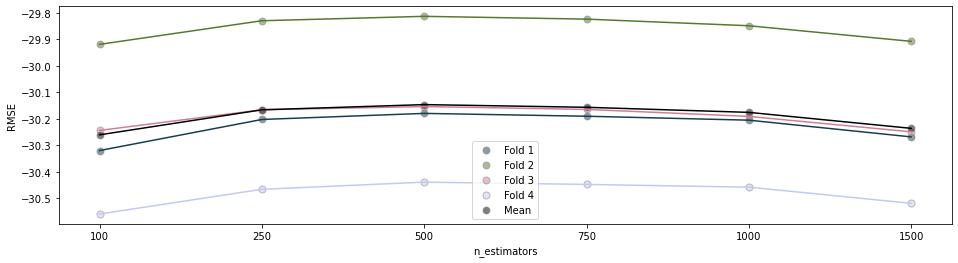

In [16]:
# Coarse tune of n_estimators
grid_params0 = { 'n_estimators': [100,250,500,750,1000,1500]}
xgb_reg, results0 = tuning_function(xgb_reg, X_train, y_train, grid_params0)
plot_gridsearch(grid_params0,results0)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
Best parameters: {'n_estimators': 500}
Lowest RMSE:  30.146183967590332


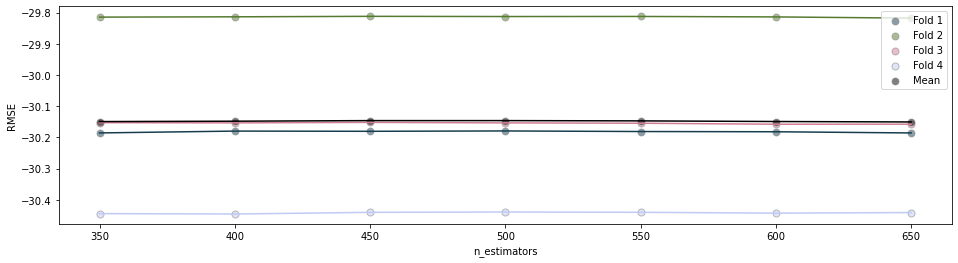

In [17]:
# Fine tune n_estimators
grid_params0 = { 'n_estimators': [350,400,450,500,550,600,650]}
xgb_reg, results0 = tuning_function(xgb_reg, X_train, y_train, grid_params0)
plot_gridsearch(grid_params0,results0)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best parameters: {'max_depth': 8, 'min_child_weight': 28}
Lowest RMSE:  30.13835048675537


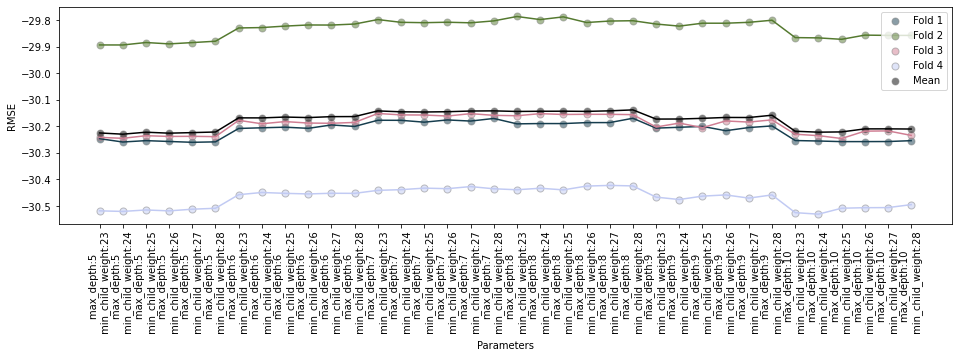

In [18]:
# max_depth & min_child_weight
grid_params1 = { 'max_depth': [5,6,7,8,9,10],
                 'min_child_weight': [23,24,25,26,27,28]}
xgb_reg, results1 = tuning_function(xgb_reg, X_train, y_train, grid_params1)
plot_gridsearch(grid_params1,results1)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters: {'gamma': 0.0}
Lowest RMSE:  30.187232494354248


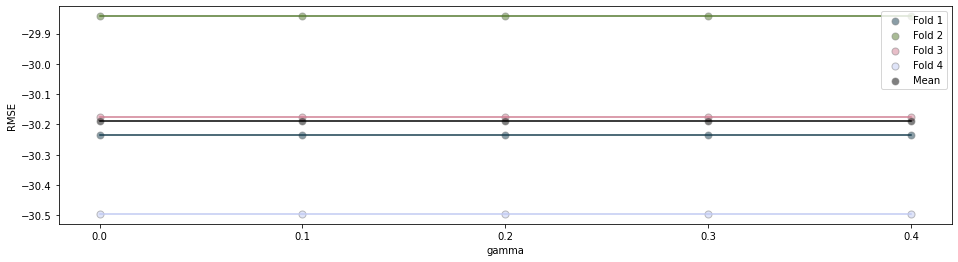

In [19]:
# gamma 
grid_params2 = { 'gamma': [i/10.0 for i in range(0,5)]}
xgb_reg, results2 = tuning_function(xgb_reg, X_train, y_train, grid_params2)
plot_gridsearch(grid_params2,results2)

Fitting 4 folds for each of 42 candidates, totalling 168 fits
Best parameters: {'colsample_bytree': 0.9, 'subsample': 0.85}
Lowest RMSE:  30.1425142288208


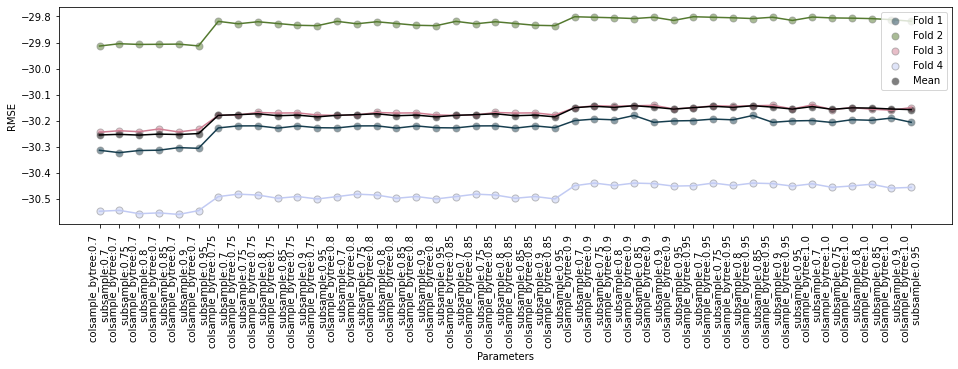

In [20]:
# subsample & colsample_bytree
grid_params3 = { 'subsample':[i/100.0 for i in range(70,100,5)],
                 'colsample_bytree':[i/100.0 for i in range(70,105,5)]}
xgb_reg, results3 = tuning_function(xgb_reg, X_train, y_train, grid_params3)
plot_gridsearch(grid_params3,results3)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best parameters: {'reg_alpha': 100, 'reg_lambda': 0.01}
Lowest RMSE:  30.1343412399292


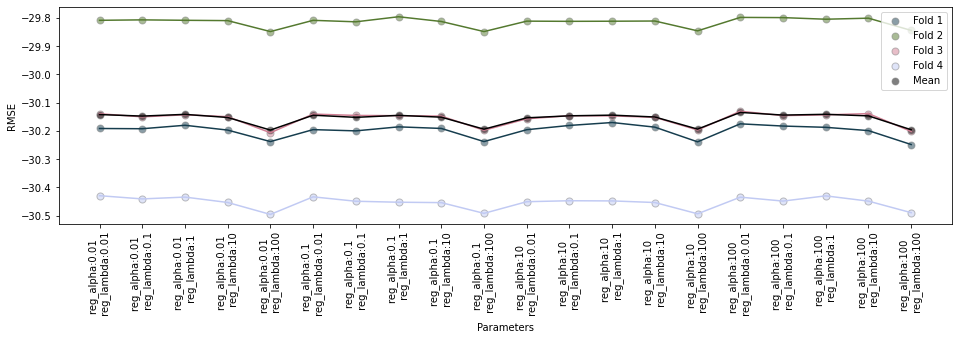

In [21]:
# Coarse tune of reg_alpha & reg_lambda
grid_params4 = { 'reg_alpha': [1e-2,0.1,10,100],
                 'reg_lambda': [1e-2,0.1,1,10,100]}
xgb_reg, results4 = tuning_function(xgb_reg, X_train, y_train, grid_params4)
plot_gridsearch(grid_params4,results4)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters: {'reg_alpha': 150, 'reg_lambda': 0.005}
Lowest RMSE:  30.13301706314087


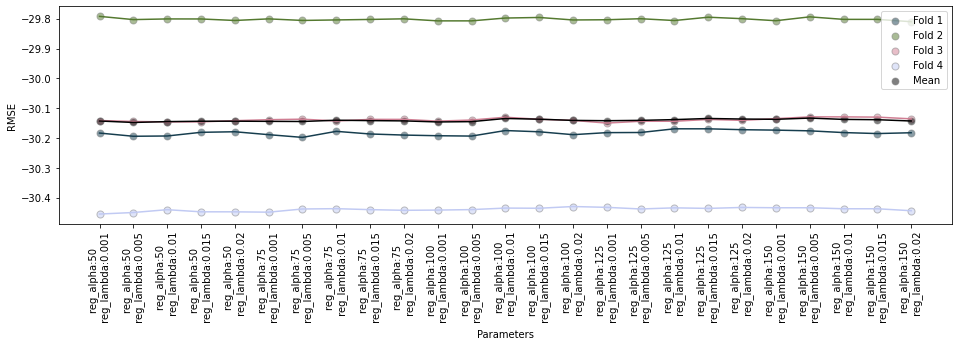

In [22]:
# Fine tune of reg_alpha & reg_lambda
grid_params4 = { 'reg_alpha': [50,75,100,125,150],
                 'reg_lambda': [0.001,0.005,0.01,0.015,0.02]}
xgb_reg, results4 = tuning_function(xgb_reg, X_train, y_train, grid_params4)
plot_gridsearch(grid_params4,results4)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters: {'n_estimators': 5000}
Lowest RMSE:  29.979299068450928


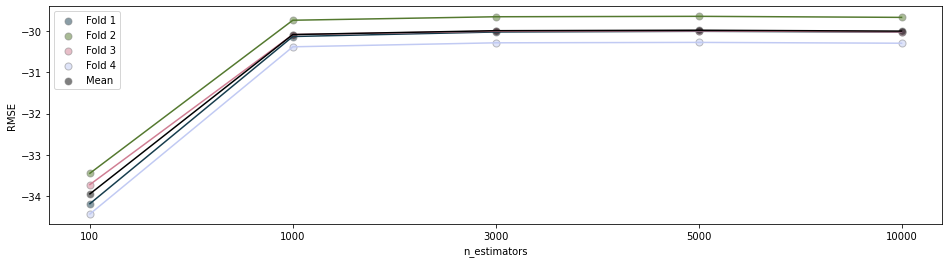

In [23]:
# reduce learning rate and re-tune for n-estimators
xgb_reg = xgb_reg.set_params(learning_rate=0.01)
grid_params5 = { 'n_estimators': [100,1000,3000,5000,10000]}
xgb_reg, results5 = tuning_function(xgb_reg, X_train, y_train, grid_params5)
plot_gridsearch(grid_params5,results5)

In [24]:
# to avoid overfitting we are going to use 3000 as the n_estimators as performance does not improve drastically. 
xgb_reg = xgb_reg.set_params(n_estimators=3000)

In [25]:
xgb_reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eval_metric='rmse', gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=28, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=20,
             reg_alpha=150, reg_lambda=0.005, scale_pos_weight=1, seed=20,
             subsample=0.85, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Test on different years 

- note the model has been tuned for 2017 as the test year, but good to check the others..

In [26]:
test,train,test_no_NaN,train_no_NaN,X_test,y_test,X_train,y_train = pre_processes_data(2016,biases)
y_pred,my_model1 = run_model(xgb_reg,X_train,y_train,X_test,y_test)

RMSE:  30.272089
R^2:  0.5423230500129647


In [27]:
test,train,test_no_NaN,train_no_NaN,X_test,y_test,X_train,y_train = pre_processes_data(2017,biases)
y_pred,my_model2 = run_model(xgb_reg,X_train,y_train,X_test,y_test)

RMSE:  29.704342
R^2:  0.5514791953273712


In [28]:
test,train,test_no_NaN,train_no_NaN,X_test,y_test,X_train,y_train = pre_processes_data(2018,biases)
y_pred,my_model3 = run_model(xgb_reg,X_train,y_train,X_test,y_test)

RMSE:  29.52371
R^2:  0.5546271290760575


## Save it 

In [29]:
# Save the model out 
xgb_reg.save_model('/g/data/jk72/slf563/ACCESS/ML_data/SO_2015-2019_testyr_{}_training_{}_v2.txt'.format(test_year,jobname))

*********
# Calculate SHAP features 

Going to calculate SHAP features on the entire dataset, so need to run XGBoost for the whole period
- read in saved model 
- generate data
- run SHAP 
- make some plots for sanity checks 

## Read in model 
(just so we don't have to retune/train XGBoost if we dont need to)

In [30]:
xgb_reg_saved = xgb.XGBRegressor()
xgb_reg_saved.load_model('/g/data/jk72/slf563/ACCESS/ML_data/SO_2015-2019_testyr_{}_training_{}_v2.txt'.format(2017,jobname))

In [31]:
xgb_reg_saved

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eval_metric='rmse', gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=28, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=20,
             reg_alpha=150, reg_lambda=0.005, scale_pos_weight=1, seed=20,
             subsample=0.85, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Processes, retrain and predict on full data set, then run SHAP 
- Training and the preducting full data set does lead to some overfitting, but we want the full data set for our subsequent analysis.  

In [32]:
data = biases.stack(y=('time','lon','lat')) # flatten 
data_pd = data.to_dataframe().dropna() # get rid of nans

data_is_NaN = data.to_dataframe().notnull()
data_no_NaN = data_is_NaN.all(axis=1) # need this for later when we restack the data

xgb_reg_shap = xgb_reg_saved.fit(data_pd[predictors],data_pd[target]) # fit 
y_pred = xgb_reg_shap.predict(data_pd[predictors]) # predict 

In [33]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_reg_shap,feature_perturbation='interventional')
# Calculate Shap values. Takes a while.
shap_values = explainer(data_pd[predictors],check_additivity=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Do some sanity checks

In [34]:
print('RMSE: ', np.sqrt(mean_squared_error(data_pd[target], y_pred)))
print('R^2: ', r2_score(data_pd[target], y_pred))

RMSE:  29.046822
R^2:  0.5738726963820027


In [35]:
print('Base value: ', explainer.expected_value)

Base value:  11.504157


In [36]:
print('Sum of shap vales, plus base values minus prediction should equal zero:')
np.round((shap_values.values.sum(1)+explainer.expected_value - y_pred).mean(),4)

Sum of shap vales, plus base values minus prediction should equal zero:


0.0

## Plot some of the default SHAP plots

In [39]:
shap.initjs()

8it [05:18, 45.55s/it]                                                          


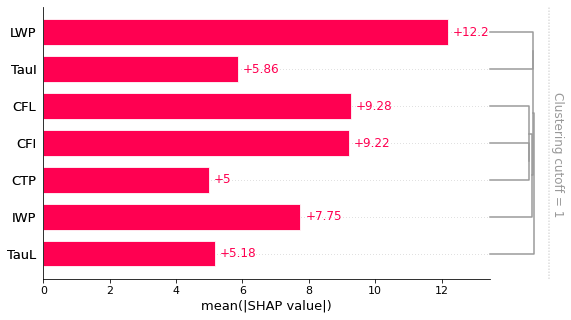

In [40]:
clustering = shap.utils.hclust(data_pd[predictors],data_pd[target])
shap.plots.bar(shap_values,show=False,clustering=clustering,clustering_cutoff=1,)
plt.savefig(
    '/home/563/slf563/code/gadi/jk72/ACCESS-CM2_analysis/COSP_analysis/Machine_learning_paper/plots/bar_plot_clustered_force_{}.pdf'.format(jobname),
    bbox_inches = 'tight')

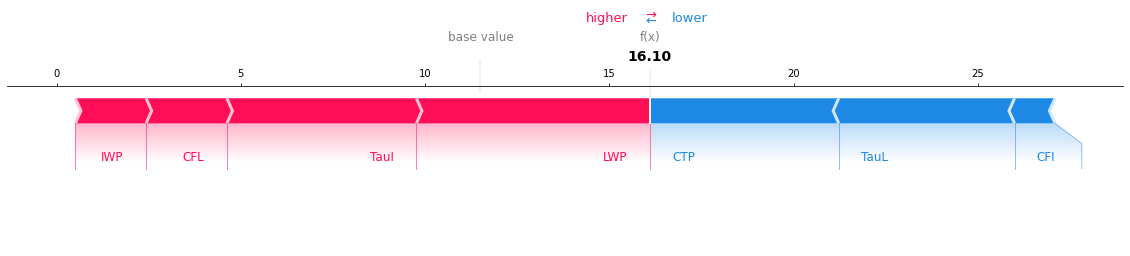

In [41]:
shap.plots.force(explainer.expected_value,shap_values.values[800],feature_names=predictors,show=False,
                 matplotlib=True).savefig('/home/563/slf563/code/gadi/jk72/ACCESS-CM2_analysis/COSP_analysis/Machine_learning_paper/plots/SHAP_force_{}.pdf'.format(jobname),bbox_inches = 'tight')

# Restack and save shap values into xarray 

Reorganise results into time, lat, lon 

In [42]:
pred = data['SWCREtoa'].copy()
pred.values[:] = [np.nan]
pred.values[data_no_NaN] = y_pred
pred = pred.unstack()

In [43]:
pd_shap_values = pd.DataFrame(shap_values.values,columns=predictors)
xr_shap_values = pd_shap_values.to_xarray()
xr_shap = data[predictors].copy()
for p in predictors:
    xr_shap[p].values[:] = np.nan
    xr_shap[p].values[data_no_NaN] = xr_shap_values[p].values
xr_shap = xr_shap.unstack()

In [44]:
pred.to_netcdf('/g/data/jk72/slf563/ACCESS/ML_data/XGBoost_predicted_SWCRE_2015-2019_{}2.nc'.format(jobname))
xr_shap.to_netcdf('/g/data/jk72/slf563/ACCESS/ML_data/SHAP_values_SWCRE_2015-2019_{}2.nc'.format(jobname))

In [45]:
def plot_biases(data,label,subplot):
    cmap='RdBu_r'
    norm = matplotlib.colors.Normalize(vmin=-40,vmax=40)
    
    ax = plt.subplot(subplot, projection=ccrs.Orthographic(140, -90))

    p = data.plot(
                cmap=cmap,
                transform=ccrs.PlateCarree(),
                ax = ax,
                norm=norm,
                add_colorbar=False,
                );
    ax.coastlines();
    plt.title('')
    plt.title(label,loc='left')
    plt.colorbar(p,orientation='horizontal',pad=0.05)
    
    return p

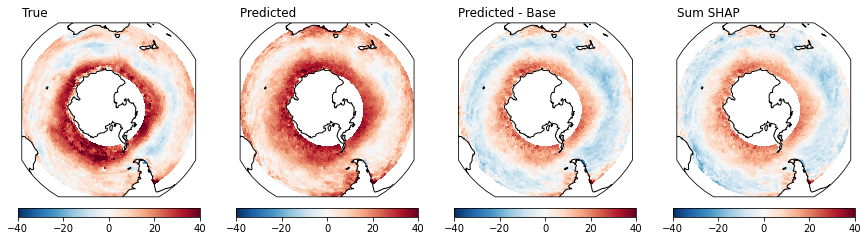

In [46]:
xr_shap_total = xr_shap['LWP']+xr_shap['IWP']+xr_shap['CFL']+xr_shap['CFI']+xr_shap['TauL']+\
                 xr_shap['TauL']+xr_shap['CTP']

fig = plt.figure(figsize=(15,4))
   
#********************************************************************************************   

p2 = plot_biases((biases['SWCREtoa']).mean('time'),'True ',141)
                 
p2 = plot_biases(pred.mean('time').T,'Predicted ',142)

p2 = plot_biases(pred.mean('time').T-explainer.expected_value,'Predicted - Base',143)

p2 = plot_biases(xr_shap_total.mean('time').T,'Sum SHAP ',144)